In [27]:

import os
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from pathlib import Path
from PIL import Image


In [28]:
class CurveDataset(Dataset):
    def __init__(self, metadata, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.metadata = metadata["curves"]
        self.transform = transform or transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ]
        )
        #X coordinates are same for all curves
        self.x_samples = [point[0] for point in self.metadata[0]["sample_points_mm"]]

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        item = self.metadata[idx]
        image_path = self.root_dir / item["image_path"]
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        points = item["sample_points_mm"]

        #Get y coordinates
        y_points = [point[1] for point in points]
        label = torch.tensor(y_points, dtype=torch.float32)
        return image, label


class CurveTypeDataset(Dataset):
    def __init__(self, metadata, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.metadata = metadata["curves"]
        self.transform = transform or transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ]
        )
        self.curve_type_mapping = {
            "linear": 0,
            "quadratic": 1,
            "cubic": 2,
            "exponential": 3,
            "sinusoidal": 4,
        }

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        item = self.metadata[idx]
        image_path = self.root_dir / item["image_path"]
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        #Get curve type
        curve_type = item["equation_type"]
        label = self.curve_type_mapping[curve_type] 

        label = torch.tensor(
            label, dtype=torch.long
        ) 

        return image, label


In [29]:

class CurvePointCNN(nn.Module):
    def __init__(self, max_coefficients=4):
        super(CurvePointCNN, self).__init__()
        # Use a pre-trained model
        self.pretrained = models.resnet50(pretrained=True)
        in_features = self.pretrained.fc.in_features
        self.pretrained.fc = nn.Linear(in_features, int(in_features / 2))
        self.fc1 = nn.Linear(int(in_features / 2), int(in_features / 4))
        
        #Return 20 points for each curve
        self.fc2 = nn.Linear(int(in_features / 4), 20)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, x, num_coefficients=None):
        output = self.pretrained(x)
        output = self.relu(output)
        output = self.fc1(output)
        output = self.relu(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output


class CurveTypeCNN(nn.Module):
    def __init__(self, num_classes=5):
        #Return 5 types of curves
        super(CurveTypeCNN, self).__init__()
        # Use a pre-trained model
        self.pretrained = models.resnet50(pretrained=True)

        in_features = self.pretrained.fc.in_features
        self.pretrained.fc = nn.Linear(in_features, int(in_features / 2))
        self.fc1 = nn.Linear(int(in_features / 2), int(in_features / 4))
        self.fc2 = nn.Linear(int(in_features / 4), num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pretrained(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [30]:
def train_curve_type_model(model, train_loader, val_loader, num_epochs=25):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")


    #Set up the model, optimizer, and loss function
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    loss_function = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            batch_loss = loss_function(outputs, labels)
            batch_loss.backward()
            optimizer.step()

            running_loss += batch_loss.item()


            #Get predicted class
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                batch_loss = loss_function(outputs, labels)

                running_val_loss += batch_loss.item()

                #Get predicted class
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

        scheduler.step()

        print(
            f"Epoch {epoch+1}/{num_epochs}, "
            f"Train Loss: {epoch_train_loss:.4f}, "
            f"Train Acc: {train_accuracy:.2f}%, "
            f"Val Loss: {epoch_val_loss:.4f}, "
            f"Val Acc: {val_accuracy:.2f}%"
        )
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss", color="blue")
    plt.plot(val_losses, label="Val Loss", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Losses")
    plt.legend()
    return model, train_losses, val_losses, val_accuracies



def train_model(model, train_loader, val_loader, num_epochs=25):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=3)

    train_losses = []
    val_losses = []
    loss_function = nn.MSELoss()
    for epoch in range(num_epochs):
        # Training 
        model.train()
        running_loss = 0.0
        total = 0
        correct = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            #Get predicted points
            output = model(images)
            loss = loss_function(output, labels)
            
            loss.backward()
            optimizer.step()
  

            running_loss += loss.item()
            

        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)


        # Validation phase
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                output = model(images)
                val_loss = loss_function(output, labels)
                running_val_loss += val_loss.item()

        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)

        scheduler.step(epoch_val_loss)

        print(
            f"Epoch {epoch+1}/{num_epochs}, "
            f"Train Loss: {epoch_train_loss:.4f}, "
            f"Val Loss: {epoch_val_loss:.4f}, "
        )
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss", color="blue")
    plt.plot(val_losses, label="Val Loss", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Losses")
    plt.legend()
    return model, train_losses, val_losses


In [31]:
def test_curve_type_model(model, test_loader):
    """Evaluate the model on the test set"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    loss_function = nn.CrossEntropyLoss()
    
    # Test model, turn off gradients
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            
            batch_loss = loss_function(outputs, labels)

            running_loss += batch_loss.item()

            #Get predicted class
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return test_loss, accuracy


def test_model(model, curve_model, test_loader):
    """Evaluate the model on the test set using predicted curve types"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    curve_model = curve_model.to(device)
    model.eval()
    curve_model.eval()

    loss_function = nn.MSELoss()

    running_loss = 0.0
    # Test model, turn off gradients
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)

            #Calculate loss between the two curves
            test_loss = loss_function(output, labels)
            running_loss += test_loss.item()
          

    test_loss = running_loss / len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")

    return test_loss

In [32]:
def visualize_curve_type_predictions(model, test_loader, num_examples=5):
    """Visualize model predictions against ground truth for some test examples"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    fig, axes = plt.subplots(num_examples, 1, figsize=(12, 4 * num_examples))

    examples_seen = 0
    curve_type_mapping = {
        0: "linear",
        1: "quadratic",
        2: "cubic",
        3: "exponential",
        4: "sinusoidal",
    }

    # Test examples
    with torch.no_grad():
        for images, labels in test_loader:

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1) 
            
            batch_size = images.shape[0]
            # Plot each example in the batch
            for i in range(batch_size):
                if examples_seen >= num_examples:
                    break
                ax = axes[examples_seen]
                # Get the actual and predicted curve types
                actual_curve_type = curve_type_mapping[labels[i].item()]
                predicted_curve_type = curve_type_mapping[predicted[i].item()]
                
                
                # Plot the image
                image = images[i].cpu().permute(1, 2, 0).numpy()
                ax.imshow(image)
                ax.set_title(
                    f"Actual: {actual_curve_type}, Predicted: {predicted_curve_type}",
                    fontsize=12,
                )
                ax.axis("off")

                examples_seen += 1

                if examples_seen >= num_examples:
                    break
                
    plt.tight_layout()
    plt.show()


def visualize_predictions(model, test_loader, num_examples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    images_seen = 0
    base_dataset = test_loader.dataset.dataset
    x_vals = torch.tensor(base_dataset.x_samples, dtype=torch.float32).to(device)

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            points_output = model(images)

            batch_size = images.shape[0]

            for i in range(batch_size):
                if images_seen >= num_examples:
                    return

                true_y = labels[i]
                pred_y = points_output[i]

                plt.figure(figsize=(6, 4))
                plt.plot(x_vals.cpu().numpy(), true_y.cpu().numpy(), label='True Curve', marker='o')
                plt.plot(x_vals.cpu().numpy(), pred_y.cpu().numpy(), label='Predicted Curve', linestyle='--')
                plt.title(f"Example {images_seen+1}")
                plt.xlabel("x")
                plt.ylabel("y")
                plt.legend()
                plt.grid(True)
                plt.show()

                images_seen += 1
            


In [33]:
# Load metadata
with open("./curve_projection_dataset/metadata.json", "r") as f:
    metadata = json.load(f)

# Create datasets
curve_dataset = CurveDataset(metadata, "./curve_projection_dataset")
curve_type_dataset = CurveTypeDataset(metadata, "./curve_projection_dataset")

# Split datasets
train_size = int(0.7 * len(curve_dataset))
val_size = int(0.15 * len(curve_dataset))
test_size = len(curve_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    curve_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)
train_curve_dataset, val_curve_dataset, test_curve_dataset = random_split(
    curve_type_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_curve_loader = DataLoader(train_curve_dataset, batch_size=32, shuffle=True)
val_curve_loader = DataLoader(val_curve_dataset, batch_size=32, shuffle=False)
test_curve_loader = DataLoader(test_curve_dataset, batch_size=32, shuffle=False)


c:\Users\Reid\miniconda3\envs\torch-gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Reid\miniconda3\envs\torch-gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda
Epoch 1/20, Train Loss: 0.8215, Train Acc: 68.03%, Val Loss: 0.4890, Val Acc: 81.73%
Epoch 2/20, Train Loss: 0.4800, Train Acc: 81.91%, Val Loss: 0.4136, Val Acc: 83.60%
Epoch 3/20, Train Loss: 0.4272, Train Acc: 83.57%, Val Loss: 0.3889, Val Acc: 85.20%
Epoch 4/20, Train Loss: 0.3541, Train Acc: 87.17%, Val Loss: 0.3095, Val Acc: 88.53%
Epoch 5/20, Train Loss: 0.3279, Train Acc: 88.06%, Val Loss: 0.4206, Val Acc: 88.27%
Epoch 6/20, Train Loss: 0.2951, Train Acc: 89.23%, Val Loss: 0.2861, Val Acc: 89.87%
Epoch 7/20, Train Loss: 0.2600, Train Acc: 91.14%, Val Loss: 0.3855, Val Acc: 84.80%
Epoch 8/20, Train Loss: 0.2289, Train Acc: 92.29%, Val Loss: 0.2794, Val Acc: 90.53%
Epoch 9/20, Train Loss: 0.1946, Train Acc: 92.97%, Val Loss: 0.2380, Val Acc: 91.07%
Epoch 10/20, Train Loss: 0.1543, Train Acc: 94.86%, Val Loss: 0.2290, Val Acc: 92.00%
Epoch 11/20, Train Loss: 0.1253, Train Acc: 95.69%, Val Loss: 0.3098, Val Acc: 90.80%
Epoch 12/20, Train Loss: 0.1209, Train Acc: 

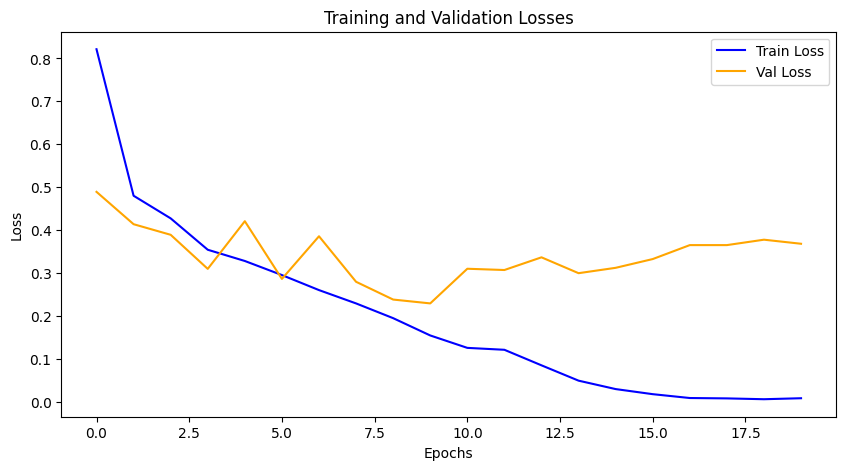

In [34]:

curve_type_model = CurveTypeCNN()

#Train curve type model
trained_curve_type_model, train_curve_losses, val_curve_losses, accuracy_curve = train_curve_type_model(
    curve_type_model, train_curve_loader, val_curve_loader, num_epochs=20
)


Using device: cuda
Epoch 1/20, Train Loss: 77.7031, Val Loss: 52.7122, 
Epoch 2/20, Train Loss: 42.2337, Val Loss: 36.9833, 
Epoch 3/20, Train Loss: 40.3044, Val Loss: 29.6092, 
Epoch 4/20, Train Loss: 31.3386, Val Loss: 16.2414, 
Epoch 5/20, Train Loss: 15.3462, Val Loss: 7.2085, 
Epoch 6/20, Train Loss: 12.8360, Val Loss: 6.6083, 
Epoch 7/20, Train Loss: 13.8395, Val Loss: 7.5649, 
Epoch 8/20, Train Loss: 11.8588, Val Loss: 8.4882, 
Epoch 9/20, Train Loss: 11.1753, Val Loss: 8.6250, 
Epoch 10/20, Train Loss: 11.4031, Val Loss: 6.4817, 
Epoch 11/20, Train Loss: 11.4390, Val Loss: 6.7359, 
Epoch 12/20, Train Loss: 10.3648, Val Loss: 6.8410, 
Epoch 13/20, Train Loss: 10.5149, Val Loss: 6.9917, 
Epoch 14/20, Train Loss: 10.1804, Val Loss: 10.1768, 
Epoch 15/20, Train Loss: 9.1722, Val Loss: 5.5195, 
Epoch 16/20, Train Loss: 8.5952, Val Loss: 5.4191, 
Epoch 17/20, Train Loss: 8.5728, Val Loss: 5.4109, 
Epoch 18/20, Train Loss: 8.7012, Val Loss: 5.3203, 
Epoch 19/20, Train Loss: 8.6070, Va

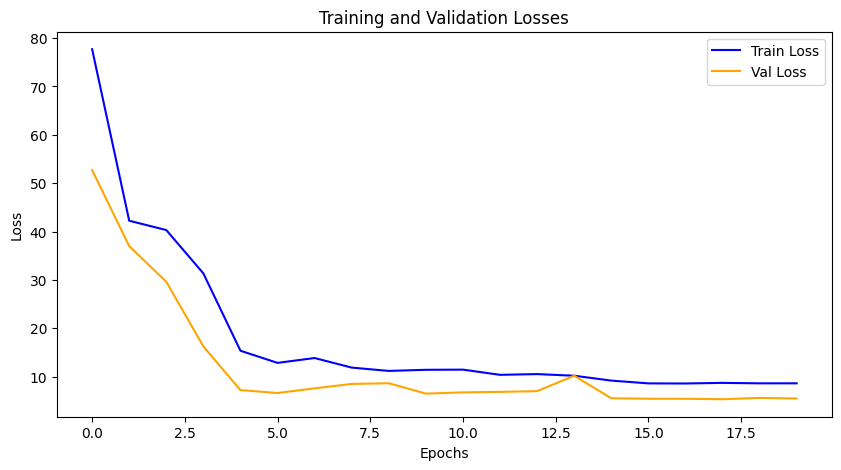

In [35]:

curve_point_model = CurvePointCNN()

#Train
trained_curve_model, train_losses, val_losses = train_model(
    curve_point_model, train_loader, val_loader, num_epochs=20
)


In [36]:
# Save the model
torch.save(trained_curve_model.state_dict(), "curve_fitting_model.pth")
torch.save(trained_curve_type_model.state_dict(), "curve_type_model.pth")
print("Model saved as curve_type_model.pth")
print("Model saved as curve_fitting_model.pth")

Model saved as curve_type_model.pth
Model saved as curve_fitting_model.pth


Test Loss: 0.4053, Accuracy: 91.87%
Test Loss: 5.3623


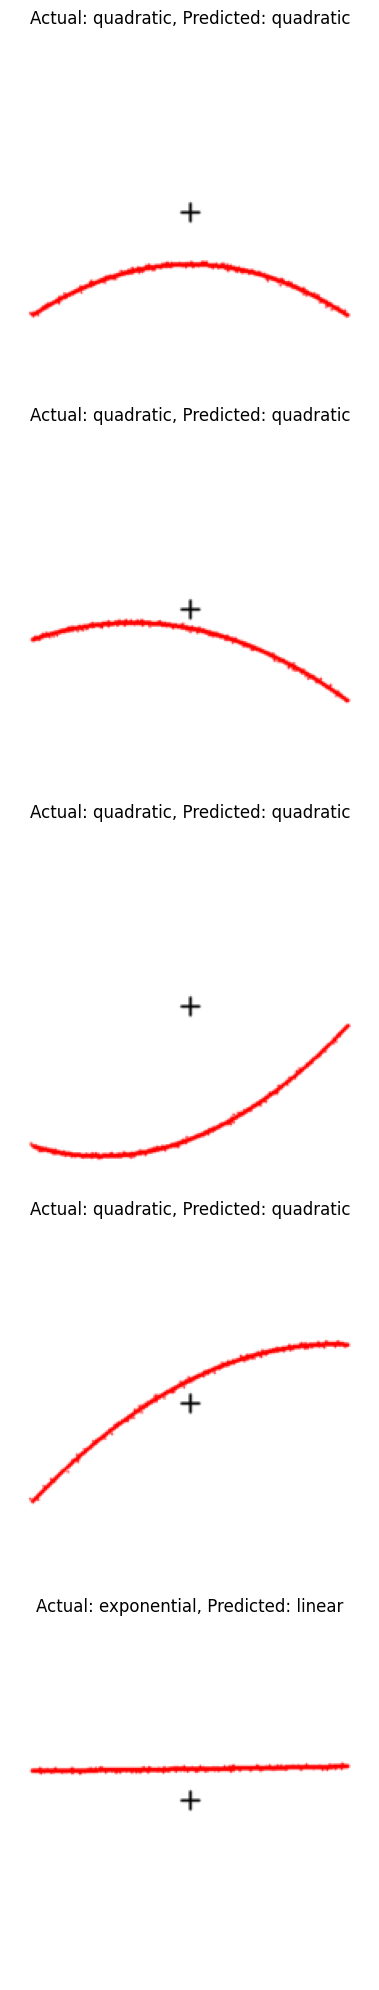

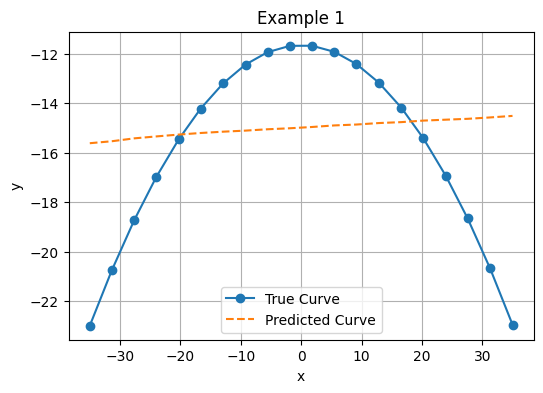

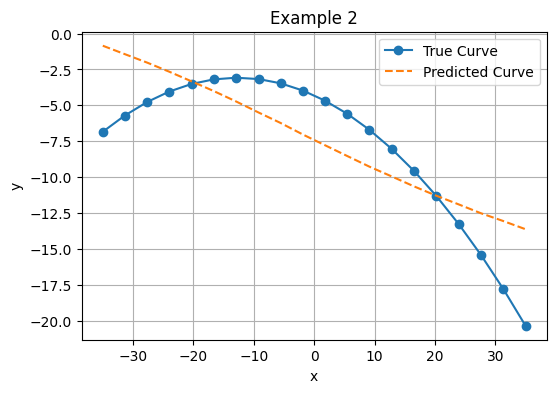

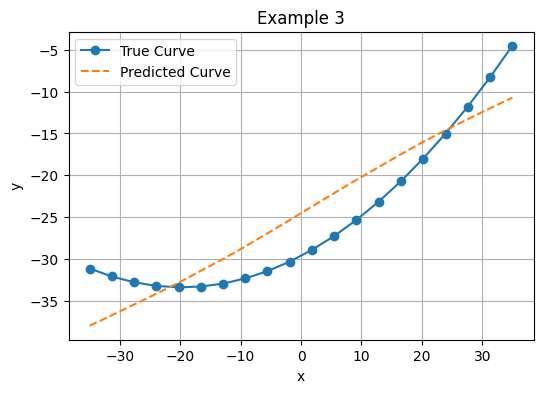

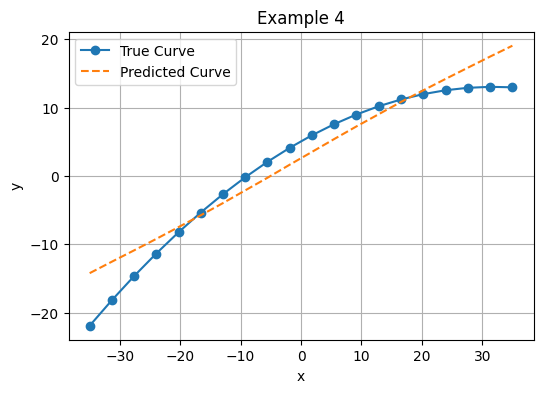

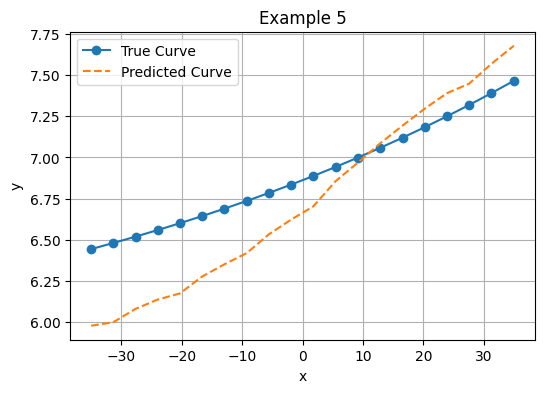

In [37]:
# Load the model
curve_type_model = CurveTypeCNN()
curve_type_model.load_state_dict(torch.load("curve_type_model.pth"))
curve_point_model = CurvePointCNN()
curve_point_model.load_state_dict(torch.load("curve_fitting_model.pth"))


# Test examples
test_curve_type_model(curve_type_model, test_curve_loader)
test_model(curve_point_model, curve_type_model, test_loader)

# Visualizations
visualize_curve_type_predictions(curve_type_model, test_curve_loader, num_examples=5)
visualize_predictions(curve_point_model, test_loader, num_examples=5)


